This notebook characterizes the dependence of sequence replay on specific model parameter combinations.

In [1]:
%reset -f
%matplotlib inline
from ast import literal_eval
from copy import deepcopy as copy
from itertools import product as cprod
import sys

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln


N_SEEDS = 10
MAX_SEED = 1000
DTCN_WDW = .1
TRJ_CUTOFF = .75
NTRJ_CUTOFF = .5
RANK_CORR_CUTOFF = .9
SPD_DTCN_WDW = .2

MIN_N_REPLAY = 5
D_SMLN_SPNT_ATVY = 10


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'W_PC_PC': 0.03, 'L_PC_PC': 0.083, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": .8},
    
    "metrics": {
        "WDW": 0.1, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }
}

# Plot dynamics regimes

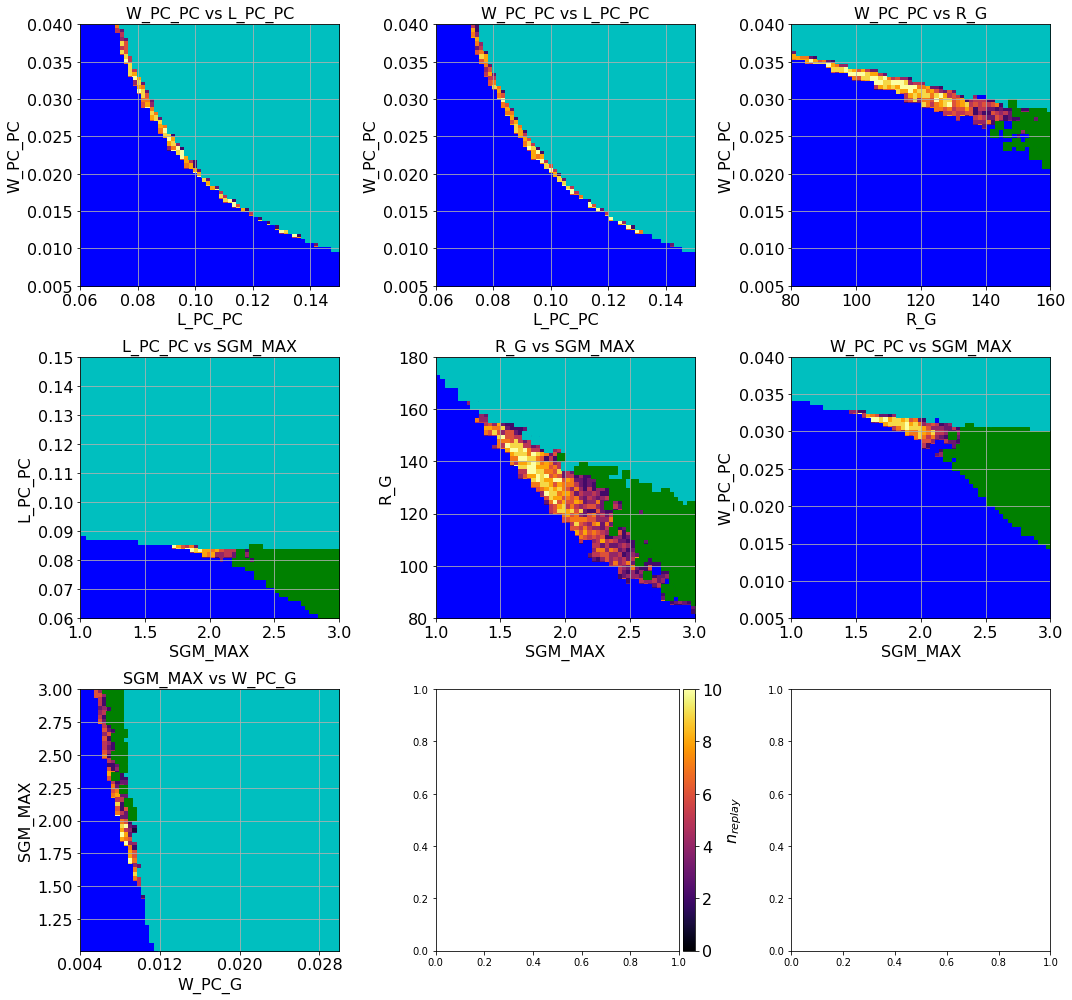

In [2]:
RSLT_FILES = [
    'replay_param_sweep_L_PC_PC_W_PC_PC_0.csv',
    'replay_param_sweep_L_PC_PC_W_PC_PC_1.csv',
    'replay_param_sweep_R_G_W_PC_PC_0.csv',
    'replay_param_sweep_SGM_MAX_L_PC_PC_0.csv',
    'replay_param_sweep_SGM_MAX_R_G_0.csv',
    'replay_param_sweep_SGM_MAX_W_PC_PC_0.csv',
    'replay_param_sweep_W_PC_G_SGM_MAX_0.csv',
]

X_TICKS = [
    None, None, np.linspace(80, 160, 5), 
    np.linspace(1, 3, 5), np.linspace(1, 3, 5), np.linspace(1, 3, 5), 
    [.004, .012, .02, .028]
]

m_paramss = []
s_paramss = []
cols = []
dfs = []
x_lims = []
y_lims = []

fig, axs = plt.subplots(3, 3, figsize=(15, 14), tight_layout=True)

for rslt_file, ax, x_ticks in zip(RSLT_FILES, axs.flatten(), X_TICKS):
    
    with open(rslt_file, 'r') as f:
        m_params = literal_eval(f.readline().strip())
        s_params = literal_eval(f.readline().strip())

    df = pd.read_csv(rslt_file, header=2, index_col=0)

    col_x = df.columns[1]
    col_y = df.columns[2]
    
    vals_x = df[col_x]
    vals_y = df[col_y]
    
    n_replay = df['N_REPLAY']
    
    im = ax.scatter(vals_x, vals_y, marker='s', s=55, c=n_replay, cmap='inferno', vmin=0, vmax=10, lw=0, zorder=0)
    
    # color non-replay units by fadeout vs blowup vs disordered
    df_fadeout = df[(n_replay < 2) & (df['N_FADEOUT'] > df['N_BLOWUP']) & (df['N_FADEOUT'] > df['N_DISORDERED'])]
    ax.scatter(df_fadeout[col_x], df_fadeout[col_y], marker='s', s=55, c='b', zorder=1)
    
    df_blowup = df[(n_replay < 2) & (df['N_BLOWUP'] > df['N_FADEOUT']) & (df['N_BLOWUP'] > df['N_DISORDERED'])]
    ax.scatter(df_blowup[col_x], df_blowup[col_y], marker='s', s=55, c='c', zorder=1)
    
    df_disordered = df[(n_replay < 2) & (df['N_DISORDERED'] > df['N_BLOWUP']) & (df['N_DISORDERED'] > df['N_FADEOUT'])]
    ax.scatter(df_disordered[col_x], df_disordered[col_y], marker='s', s=55, c='g', zorder=1)
    
    x_lim = [vals_x.min(), vals_x.max()]
    y_lim = [vals_y.min(), vals_y.max()]
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    ax.set_title('{} vs {}'.format(col_y, col_x))
    
    ax.grid()
    
    set_font_size(ax, 16)
    
    m_paramss.append(m_params)
    s_paramss.append(s_params)
    
    cols.append((col_x, col_y))
    
    dfs.append(df)
    
    x_lims.append(x_lim)
    y_lims.append(y_lim)
    
# put colorbar on unused axis
divider = make_axes_locatable(axs[2, 1])
c_ax = divider.append_axes('right', '5%', pad=0.05)
cb = fig.colorbar(im, cax=c_ax, ticks=[0, 2, 4, 6, 8, 10])
c_ax.set_ylabel('$n_{replay}$')

set_font_size(c_ax, 16)

# Plot replay speeds

v_min = 20.02074420051084
v_max = 48.09682023365608
v_min = 20.02074420051084
v_max = 47.522259651883715
v_min = 3.4822800298452607
v_max = 39.55256709247397
v_min = 20.327798356663425
v_max = 43.476866459856986
v_min = 0.7538808729618129
v_max = 41.5061117779833
v_min = 18.963309690959104
v_max = 38.18697080569286
v_min = 2.297378025929567
v_max = 38.56124509166418


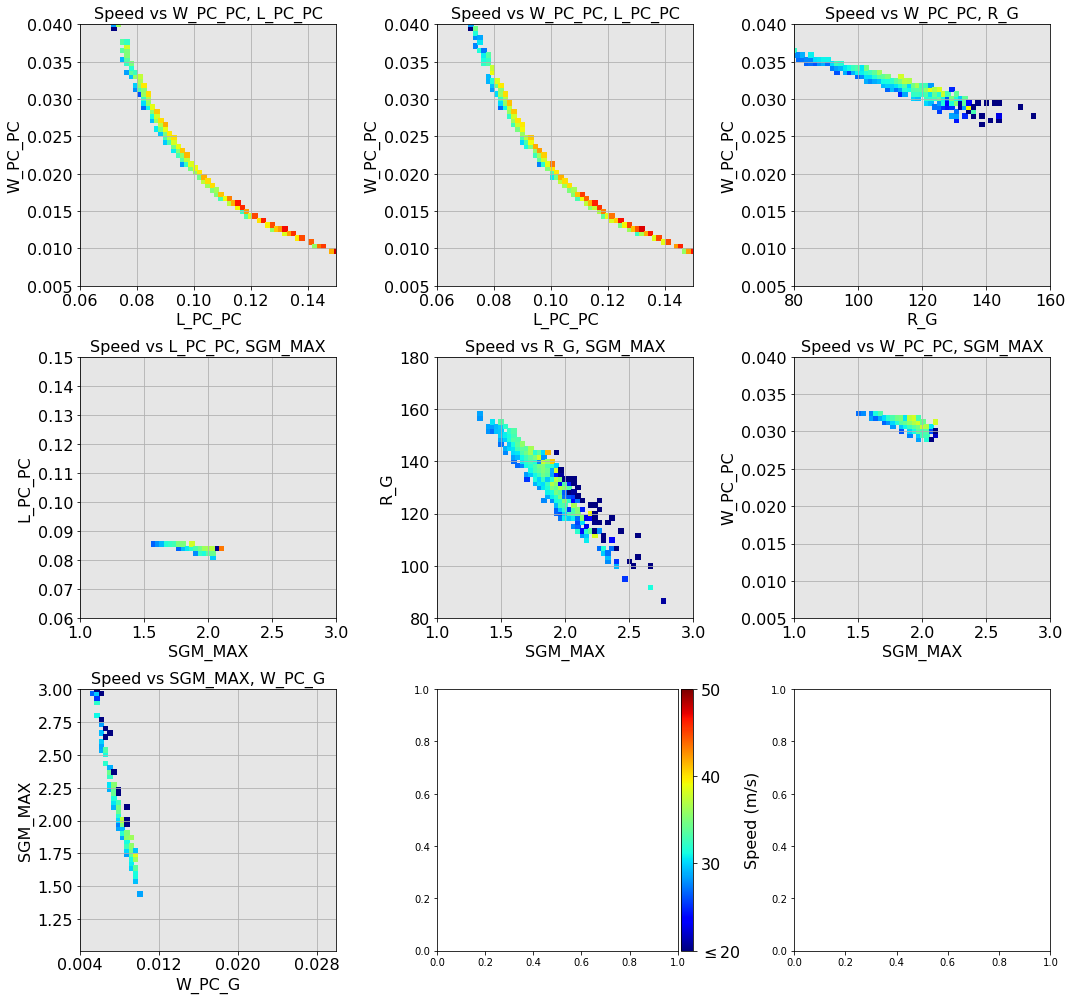

In [3]:
fig, axs = plt.subplots(3, 3, figsize=(15, 14), tight_layout=True)

V_MIN = 20
V_MAX = 50

for rslt_file, ax, x_lim, y_lim, x_ticks in zip(RSLT_FILES, axs.flatten(), x_lims, y_lims, X_TICKS):
    
    df = pd.read_csv('speed_' + rslt_file, header=2, index_col=0)
    
    col_x = df.columns[2]
    col_y = df.columns[3]
    
    vals_x = df[col_x]
    vals_y = df[col_y]
    
    n_replay = df['N_REPLAY']
    
    spds = df['MEAN_SPD']
    
    v_min = spds.min()
    v_max = spds.max()
    
    im = ax.scatter(vals_x, vals_y, marker='s', s=30, c=spds, cmap='jet', vmin=V_MIN, vmax=V_MAX, lw=0)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
        
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    
    ax.set_title('Speed vs {}, {}'.format(col_y, col_x))
    
    ax.grid()
    ax.set_facecolor((.9, .9, .9))
    
    set_font_size(ax, 16)
    
    print('v_min =', v_min)
    print('v_max =', v_max)
    
# put colorbar on unused axis
divider = make_axes_locatable(axs[2, 1])
c_ax = divider.append_axes('right', '5%', pad=0.05)
cb = fig.colorbar(im, cax=c_ax, ticks=[20, 30, 40, 50])

c_ax.set_yticklabels(['$\leq 20$', 30, 40, 50])
c_ax.set_ylabel('Speed (m/s)')

set_font_size(c_ax, 16)

# Plot spontaneous activity levels

v_min = 0.35448717948717945
v_max = 3.9958333333333327
v_min = 0.33782051282051284
v_max = 4.1580128205128215
v_min = 0.003205128205128205
v_max = 12.351602564102564
v_min = 0.009294871794871795
v_max = 23.04391025641026
v_min = 0.015705128205128205
v_max = 21.823717948717952
v_min = 0.0022435897435897434
v_max = 24.095192307692308
v_min = 0.0608974358974359
v_max = 18.813141025641023


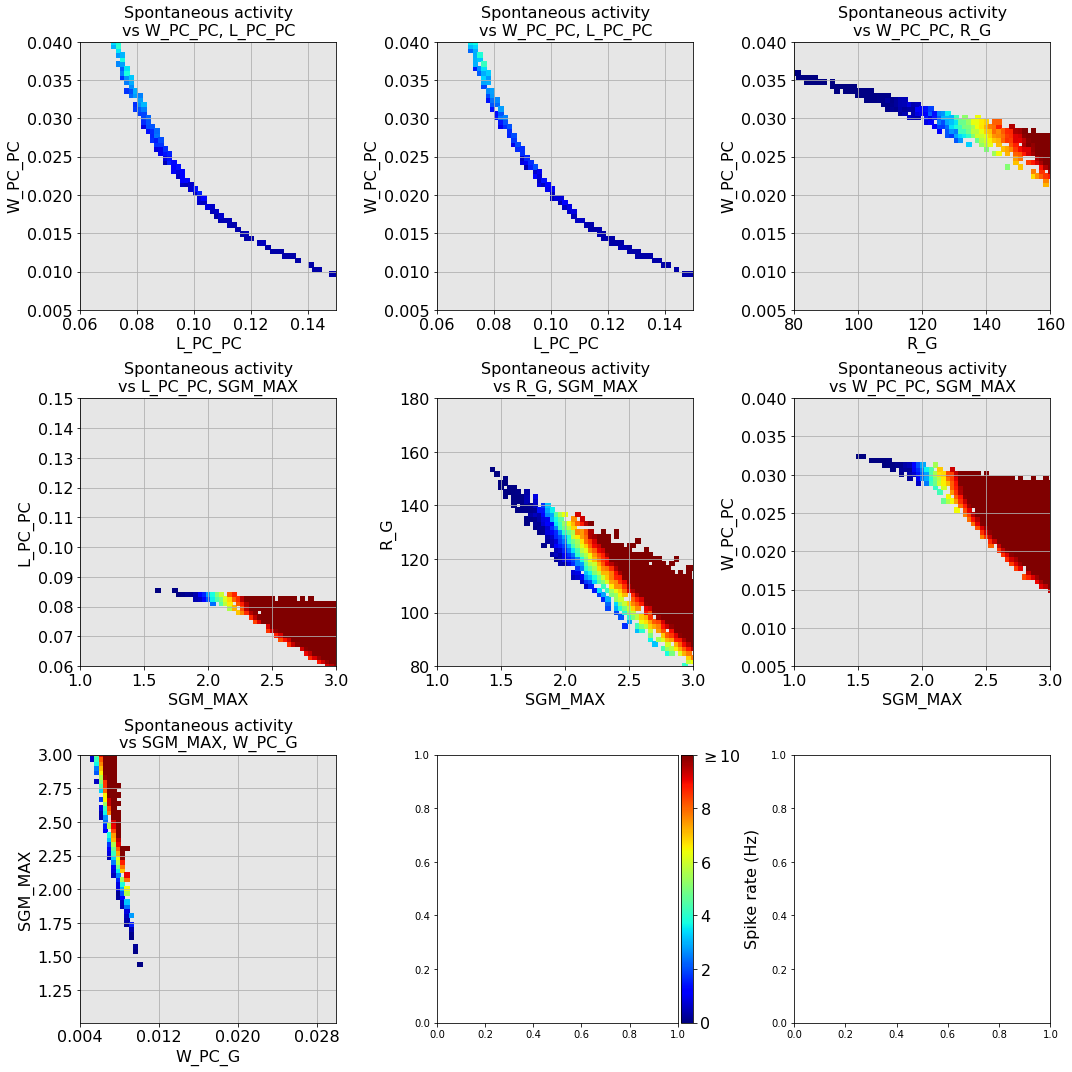

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), tight_layout=True)

V_MIN = 0
V_MAX = 10

for rslt_file, ax, x_lim, y_lim, x_ticks in zip(RSLT_FILES, axs.flatten(), x_lims, y_lims, X_TICKS):
    
    df = pd.read_csv('spnt_atvy_' + rslt_file, header=2, index_col=0)
    
    col_x = df.columns[1]
    col_y = df.columns[2]
    
    vals_x = df[col_x]
    vals_y = df[col_y]
    
    spnt_atvys = df['MEAN_SPNT_ATVY']
    
    v_min = spnt_atvys.min()
    v_max = spnt_atvys.max()
    
    im = ax.scatter(vals_x, vals_y, marker='s', s=30, c=spnt_atvys, cmap='jet', vmin=V_MIN, vmax=V_MAX, lw=0)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
        
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    
    ax.set_title('Spontaneous activity\nvs {}, {}'.format(col_y, col_x))
    
    ax.grid()
    ax.set_facecolor((.9, .9, .9))
    
    set_font_size(ax, 16)
    
    print('v_min =', v_min)
    print('v_max =', v_max)
    
# put colorbar on unused axis
divider = make_axes_locatable(axs[2, 1])
c_ax = divider.append_axes('right', '5%', pad=0.05)
cb = fig.colorbar(im, cax=c_ax, ticks=[0, 2, 4, 6, 8, 10])

c_ax.set_yticklabels([0, 2, 4, 6, 8, '$\geq 10$'])
c_ax.set_ylabel('Spike rate (Hz)')

set_font_size(c_ax, 16)

# Run param sweeps

## Define fadeout, blowup, disordered, and replay detection functions

In [5]:
def detect_rsp_type(rslt, m_params, s_params):
    # get mask over trj and non-trj PCs
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    
    sgm_cutoff = .5 * (1 + m_params['SGM_MAX'])
    
    trj_mask = (rslt.ntwk.sgm * mask_pc.astype(float)) > sgm_cutoff
    ntrj_mask = (~trj_mask) & mask_pc
    
    # get t-mask for detection wdw
    start = s_params['TRG'][0]['T']
    end = start + DTCN_WDW
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    
    # get spk cts in for trj/non-trj cells during detection wdw
    spks_trj = rslt.spks[t_mask][:, trj_mask]
    spks_ntrj = rslt.spks[t_mask][:, ntrj_mask]
    
    # get frac of trj/non-trj cells that spikes
    p_spk_trj = np.mean(spks_trj.sum(0) > 0)
    p_spk_ntrj = np.mean(spks_ntrj.sum(0) > 0)
    
    # check if fadeout or blowup
    if p_spk_trj < TRJ_CUTOFF:
        return 'fadeout'
    elif p_spk_ntrj >= NTRJ_CUTOFF:
        return 'blowup'
    
    # check if replay is ordered or not
    ## get mask over spking trj cells
    trj_spk_mask = trj_mask & (rslt.spks[t_mask].sum(0) > 0.5)
    
    ## order nrns by place field location along trj
    pfxs = rslt.ntwk.pfxs
    pfys = rslt.ntwk.pfys
    
    ### negative b/c trj is triggered to replay in reverse
    pf_order = -smln.dist_to_trj(pfxs[trj_spk_mask], pfys[trj_spk_mask], rslt.trj['x'], rslt.trj['y'])[1]
    
    ## order nrns by first spk times
    spk_order = rslt.spks[t_mask][:, trj_spk_mask].argmax(0)
    
    ## get correlation
    pf_spk_rank_corr = stats.spearmanr(pf_order, spk_order)[0]
    
    if pf_spk_rank_corr < RANK_CORR_CUTOFF:
        return 'disordered'
    else:
        return 'replay'

## Define replay speed evaluation function

In [6]:
def get_replay_speed(rslt, m_params, s_params):
    
    # get t-mask for detection wdw
    start = s_params['TRG'][0]['T']
    end = start + SPD_DTCN_WDW
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    ts = start + (np.arange(t_mask.sum()) * s_params['DT'])
    
    # get mask over spking trj PCs
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    sgm_cutoff = .5 * (1 + m_params['SGM_MAX'])
    trj_mask = (rslt.ntwk.sgm * mask_pc.astype(float)) > sgm_cutoff
    trj_spk_mask = trj_mask & (rslt.spks[t_mask].sum(0) > 0.5)
    
    # get int location along trj of spking PCs
    pfxs = rslt.ntwk.pfxs
    pfys = rslt.ntwk.pfys
    
    pf_order = smln.dist_to_trj(pfxs[trj_spk_mask], pfys[trj_spk_mask], rslt.trj['x'], rslt.trj['y'])[1]
    
    # convert int loc along trj to dist along trj
    dx = np.diff(rslt.trj['x'])
    dy = np.diff(rslt.trj['y'])
    
    ds_trj = np.concatenate([[0], np.cumsum(np.sqrt(dx**2 + dy**2))])
    
    ds = ds_trj[pf_order]
    
    # make (t_spk, d) pairs for all trj spks in SPD_DTCN_WDW
    spk_t_idxs, spk_pc_idxs = rslt.spks[t_mask][:, trj_spk_mask].nonzero()

    ds_spk = ds[spk_pc_idxs]
    ts_spk = ts[spk_t_idxs]
    
    # fit line to ds_spk vs ts_spk
    rgr = linear_model.HuberRegressor().fit(ts_spk[:, None], ds_spk)
    spd = np.abs(rgr.coef_[0])
    
    return spd

## Define spontaneous trj activity evaluation function

In [7]:
def get_spont_act_level(rslt, m_params, s_params):
    if s_params['TRG'][0]['A'] > 0:
        print('Warning, trigger detected in spontaneous activity calculation!')
    
    # get mask over trj PCs
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    sgm_cutoff = .5 * (1 + m_params['SGM_MAX'])
    trj_mask = (rslt.ntwk.sgm * mask_pc.astype(float)) > sgm_cutoff
    
    # get trj spks
    trj_spks = rslt.spks[:, trj_mask]
    
    # get avg spk rate
    spk_rate = np.mean(trj_spks.sum(0) / s_params['schedule']['D_SMLN'])
    
    return spk_rate

## Test detection functions

### Fadeout

Running smln...
Smln complete.
RSP TYPE:  fadeout


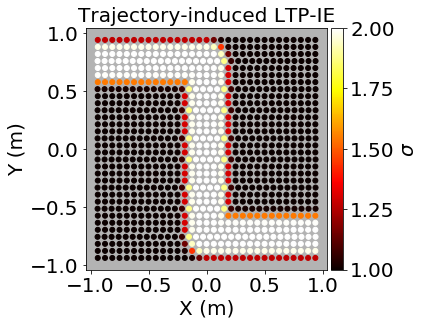

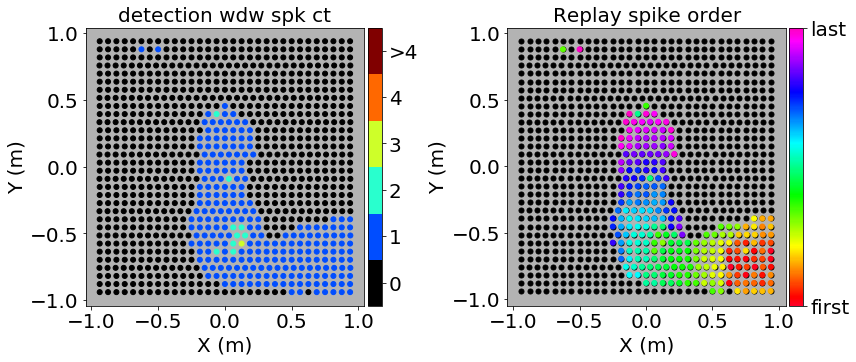

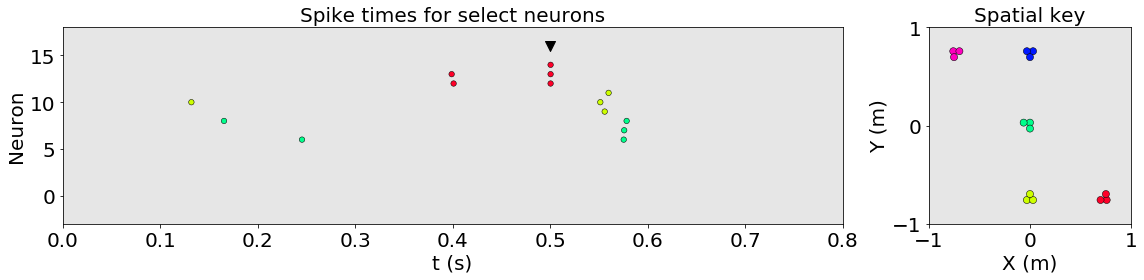

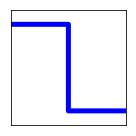

In [8]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    m_params['W_PC_PC'] = .028
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))

test()

### Blowup

Running smln...
Smln complete.
RSP TYPE:  blowup


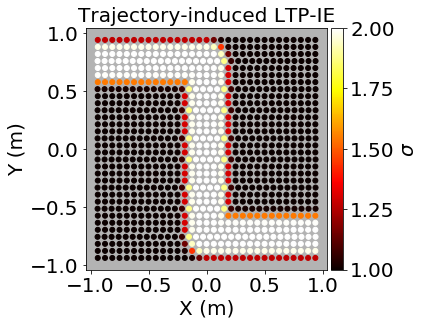

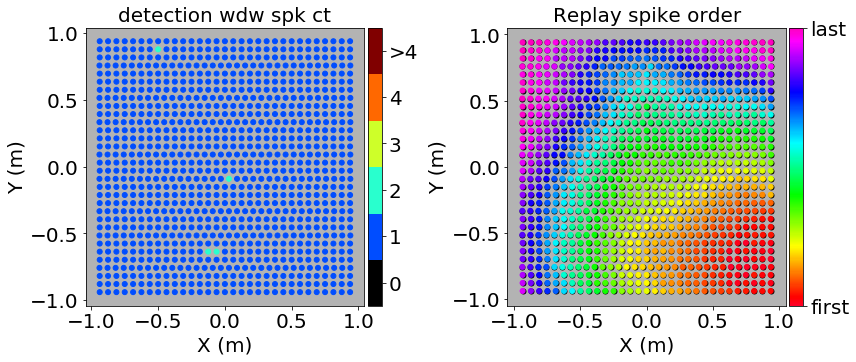

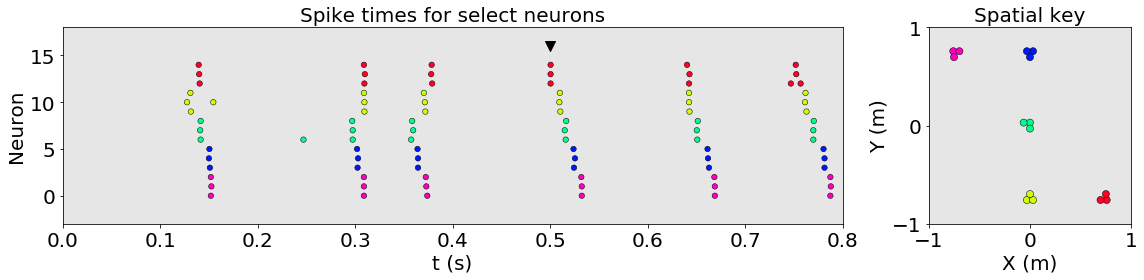

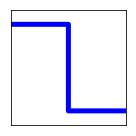

In [9]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    m_params['W_PC_PC'] = .05
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))

test()

### Disordered

Running smln...
Smln complete.
RSP TYPE:  disordered


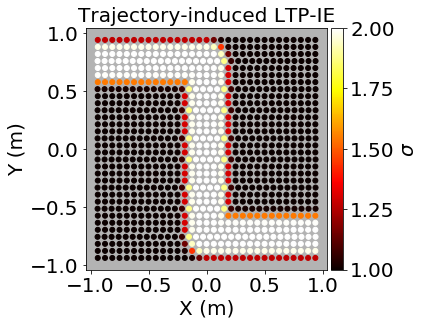

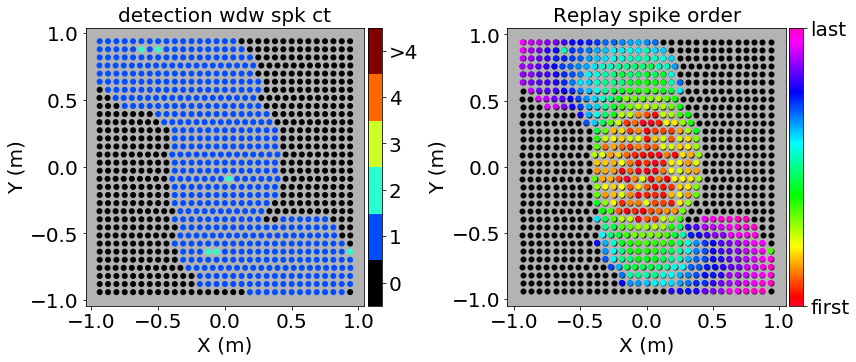

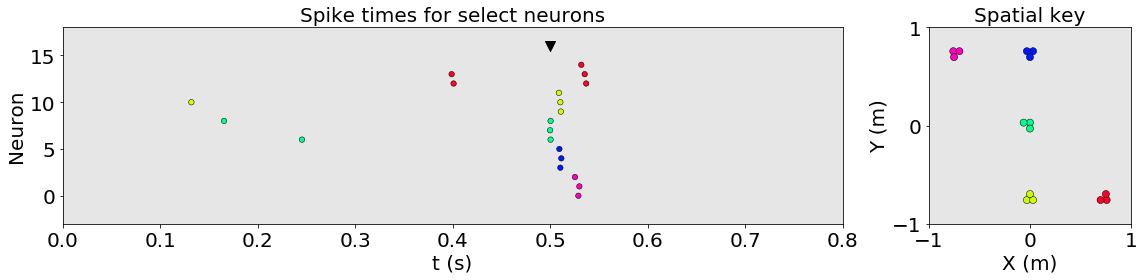

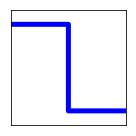

In [10]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]
    s_params['TRG'] = [{'T': 0.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 0, 'Y': 0}]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))

test()

### Replay fast

Running smln...
Smln complete.
RSP TYPE:  replay
REPLAY SPEED:  45.035219866249015 m/s


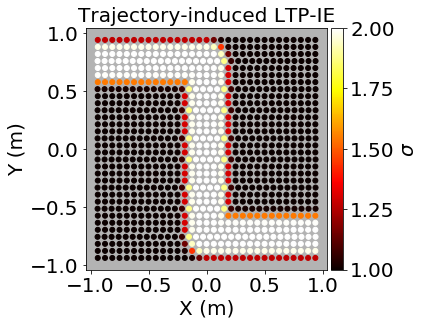

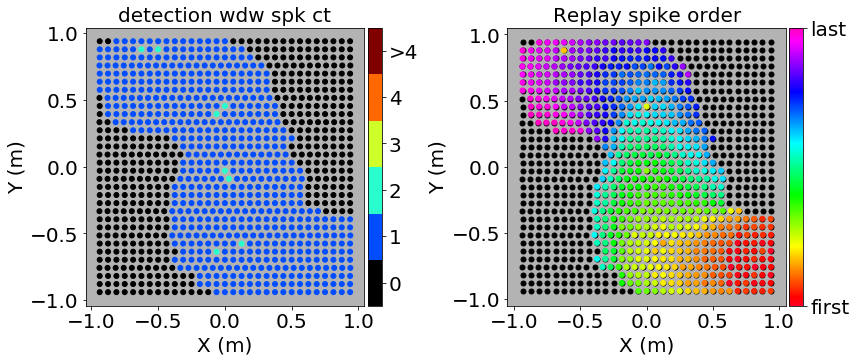

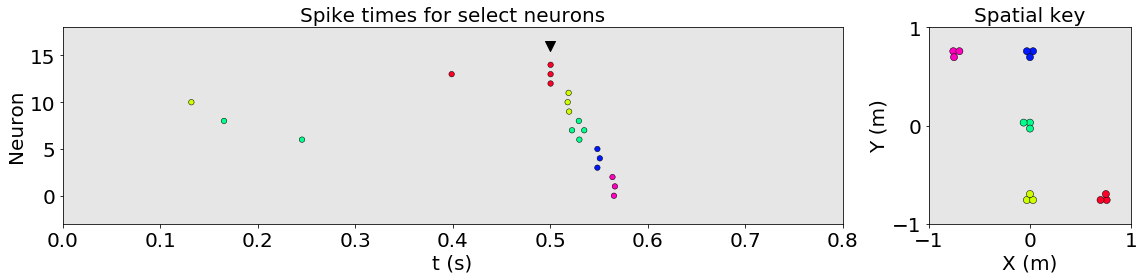

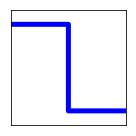

In [11]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    s_params = copy(S_PARAMS)
    
    m_params['W_PC_PC'] = 0.016
    m_params['L_PC_PC'] = 0.115
    
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))
    print('REPLAY SPEED: ', get_replay_speed(rslt, m_params, s_params), 'm/s')

test()

### Replay slow

Running smln...
Smln complete.
RSP TYPE:  replay
REPLAY SPEED:  31.716346851019356 m/s


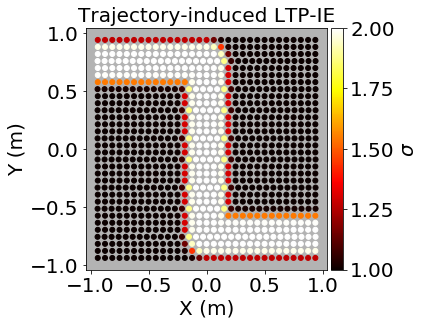

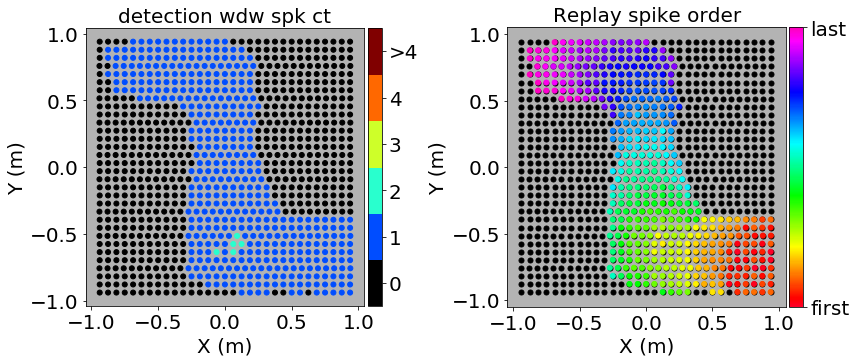

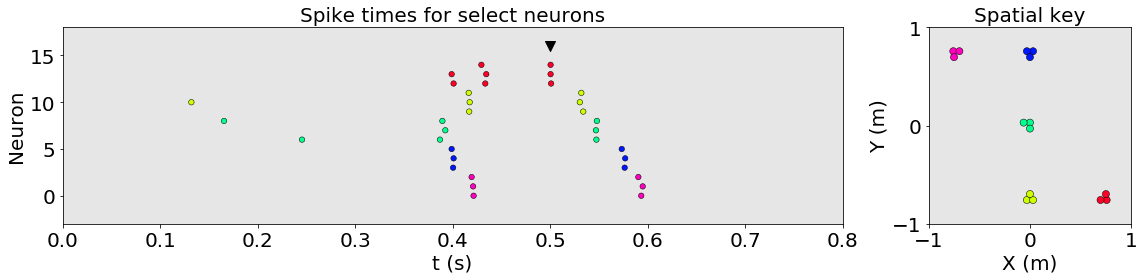

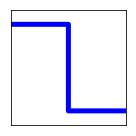

In [12]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    s_params = copy(S_PARAMS)
    
    m_params['W_PC_PC'] = 0.0325
    m_params['L_PC_PC'] = 0.08
    
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))
    print('REPLAY SPEED: ', get_replay_speed(rslt, m_params, s_params), 'm/s')

test()

## Spontaneous activity low

Running smln...
Smln complete.
Spontaneous spike rate = 0.31346153846153846 Hz


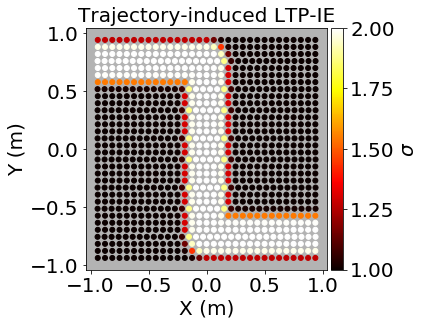

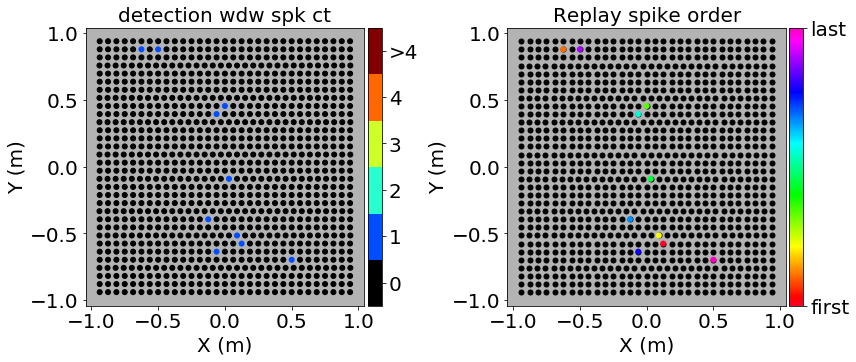

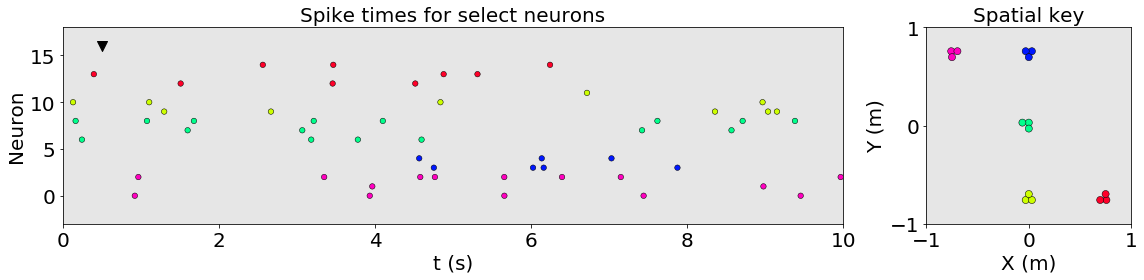

In [13]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    s_params = copy(S_PARAMS)
    
    m_params['W_PC_PC'] = 0.02
    m_params['L_PC_PC'] = 0.08
    
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]
    s_params['TRG'][0]['A'] = 0
    s_params['schedule']['D_SMLN'] = D_SMLN_SPNT_ATVY

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch=(0, 10),
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )
    
    print('Spontaneous spike rate =', get_spont_act_level(rslt, m_params, s_params), 'Hz')

test()

## Spontaneous activity high

Running smln...
Smln complete.
Spontaneous spike rate = 4.587179487179488 Hz


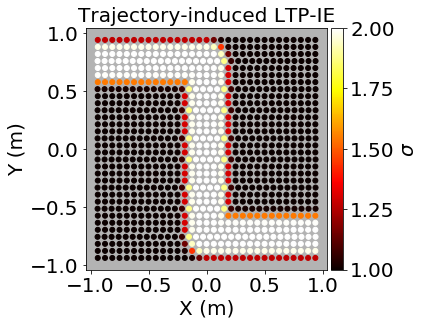

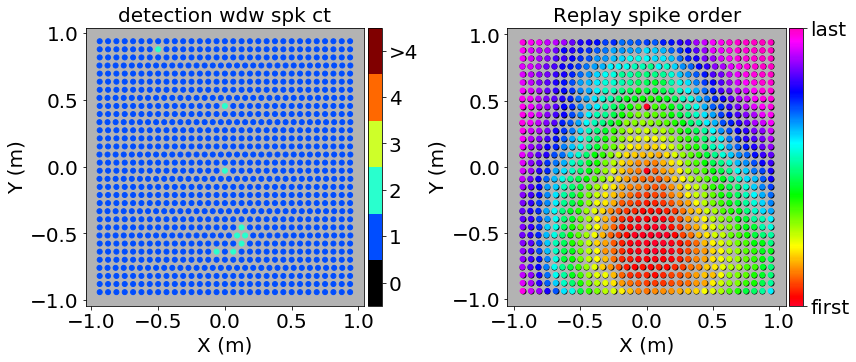

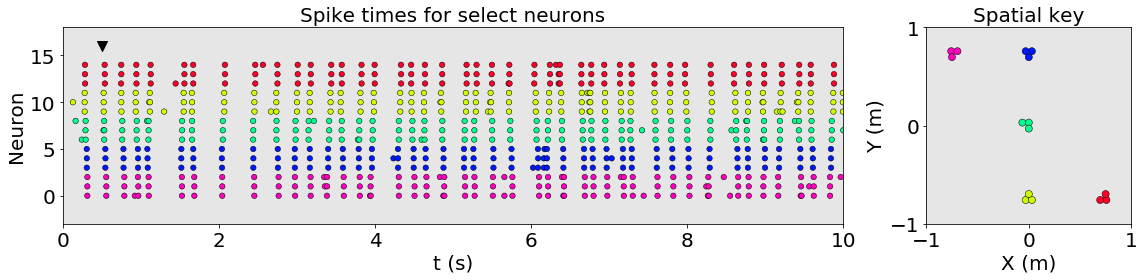

In [14]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    s_params = copy(S_PARAMS)
    
    m_params['W_PC_PC'] = 0.04
    m_params['L_PC_PC'] = 0.08
    
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]
    s_params['TRG'][0]['A'] = 0
    s_params['schedule']['D_SMLN'] = D_SMLN_SPNT_ATVY

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch=(0, 10),
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )
    
    print('Spontaneous spike rate =', get_spont_act_level(rslt, m_params, s_params), 'Hz')

test()

# Param sweeps

## Speed measurements 0

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_L_PC_PC_W_PC_PC_0.csv'
SAVE_FILE = 'speed_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running speed measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:
    
    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'N_REPLAY', 'MEAN_SPD', col_x, col_y, 'N_FADEOUT', 'N_BLOWUP', 'N_DISORDERED'] + \
    sum([['RSP_{}'.format(ctr), 'SEED_{}'.format(ctr)] for ctr in range(N_SEEDS)], [])

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = df_load['N_REPLAY'] > MIN_N_REPLAY

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    s_params_ = copy(s_params)

    # loop over seeds
    n_replay = 0
    n_fadeout = 0
    n_blowup = 0
    n_disordered = 0

    spds = []

    for seed_ctr in range(N_SEEDS):
        s_params_['RNG_SEED'] = np.random.randint(MAX_SEED)

        rslt = smln.run(m_params_, s_params_)

        rsp_type = detect_rsp_type(rslt, m_params_, s_params_)

        if rsp_type == 'fadeout':
            n_fadeout += 1
        elif rsp_type == 'blowup':
            n_blowup += 1
        elif rsp_type == 'disordered':
            n_disordered += 1
        elif rsp_type == 'replay':
            n_replay += 1
            spds.append(get_replay_speed(rslt, m_params_, s_params_))

        save_dict['RSP_{}'.format(seed_ctr)] = rsp_type
        save_dict['SEED_{}'.format(seed_ctr)] = s_params_['RNG_SEED']

    save_dict['N_REPLAY'] = n_replay
    save_dict['N_FADEOUT'] = n_fadeout
    save_dict['N_BLOWUP'] = n_blowup
    save_dict['N_DISORDERED'] = n_disordered

    if spds:
        save_dict['MEAN_SPD'] = np.mean(spds)

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running speed measurement smlns for file: replay_param_sweep_L_PC_PC_W_PC_PC_0.csv 


Running trial 1/117
..................................................
Running trial 51/117
..................................................
Running trial 101/117
.................

## Speed measurements 1

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_L_PC_PC_W_PC_PC_1.csv'
SAVE_FILE = 'speed_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running speed measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:
    
    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'N_REPLAY', 'MEAN_SPD', col_x, col_y, 'N_FADEOUT', 'N_BLOWUP', 'N_DISORDERED'] + \
    sum([['RSP_{}'.format(ctr), 'SEED_{}'.format(ctr)] for ctr in range(N_SEEDS)], [])

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = df_load['N_REPLAY'] > MIN_N_REPLAY

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    s_params_ = copy(s_params)

    # loop over seeds
    n_replay = 0
    n_fadeout = 0
    n_blowup = 0
    n_disordered = 0

    spds = []

    for seed_ctr in range(N_SEEDS):
        s_params_['RNG_SEED'] = np.random.randint(MAX_SEED)

        rslt = smln.run(m_params_, s_params_)

        rsp_type = detect_rsp_type(rslt, m_params_, s_params_)

        if rsp_type == 'fadeout':
            n_fadeout += 1
        elif rsp_type == 'blowup':
            n_blowup += 1
        elif rsp_type == 'disordered':
            n_disordered += 1
        elif rsp_type == 'replay':
            n_replay += 1
            spds.append(get_replay_speed(rslt, m_params_, s_params_))

        save_dict['RSP_{}'.format(seed_ctr)] = rsp_type
        save_dict['SEED_{}'.format(seed_ctr)] = s_params_['RNG_SEED']

    save_dict['N_REPLAY'] = n_replay
    save_dict['N_FADEOUT'] = n_fadeout
    save_dict['N_BLOWUP'] = n_blowup
    save_dict['N_DISORDERED'] = n_disordered

    if spds:
        save_dict['MEAN_SPD'] = np.mean(spds)

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running speed measurement smlns for file: replay_param_sweep_L_PC_PC_W_PC_PC_1.csv 


Running trial 1/123
..................................................
Running trial 51/123
..................................................
Running trial 101/123
.......................

## Speed measurements 2

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_R_G_W_PC_PC_0.csv'
SAVE_FILE = 'speed_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running speed measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:
    
    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'N_REPLAY', 'MEAN_SPD', col_x, col_y, 'N_FADEOUT', 'N_BLOWUP', 'N_DISORDERED'] + \
    sum([['RSP_{}'.format(ctr), 'SEED_{}'.format(ctr)] for ctr in range(N_SEEDS)], [])

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = df_load['N_REPLAY'] > MIN_N_REPLAY

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    s_params_ = copy(s_params)

    # loop over seeds
    n_replay = 0
    n_fadeout = 0
    n_blowup = 0
    n_disordered = 0

    spds = []

    for seed_ctr in range(N_SEEDS):
        s_params_['RNG_SEED'] = np.random.randint(MAX_SEED)

        rslt = smln.run(m_params_, s_params_)

        rsp_type = detect_rsp_type(rslt, m_params_, s_params_)

        if rsp_type == 'fadeout':
            n_fadeout += 1
        elif rsp_type == 'blowup':
            n_blowup += 1
        elif rsp_type == 'disordered':
            n_disordered += 1
        elif rsp_type == 'replay':
            n_replay += 1
            spds.append(get_replay_speed(rslt, m_params_, s_params_))

        save_dict['RSP_{}'.format(seed_ctr)] = rsp_type
        save_dict['SEED_{}'.format(seed_ctr)] = s_params_['RNG_SEED']

    save_dict['N_REPLAY'] = n_replay
    save_dict['N_FADEOUT'] = n_fadeout
    save_dict['N_BLOWUP'] = n_blowup
    save_dict['N_DISORDERED'] = n_disordered

    if spds:
        save_dict['MEAN_SPD'] = np.mean(spds)

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running speed measurement smlns for file: replay_param_sweep_R_G_W_PC_PC_0.csv 


Running trial 1/153
..................................................
Running trial 51/153
..................................................
Running trial 101/153
..................................................
Running trial 151/153
...

## Speed measurements 3

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_SGM_MAX_L_PC_PC_0.csv'
SAVE_FILE = 'speed_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running speed measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:
    
    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'N_REPLAY', 'MEAN_SPD', col_x, col_y, 'N_FADEOUT', 'N_BLOWUP', 'N_DISORDERED'] + \
    sum([['RSP_{}'.format(ctr), 'SEED_{}'.format(ctr)] for ctr in range(N_SEEDS)], [])

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = df_load['N_REPLAY'] > MIN_N_REPLAY

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    s_params_ = copy(s_params)

    # loop over seeds
    n_replay = 0
    n_fadeout = 0
    n_blowup = 0
    n_disordered = 0

    spds = []

    for seed_ctr in range(N_SEEDS):
        s_params_['RNG_SEED'] = np.random.randint(MAX_SEED)

        rslt = smln.run(m_params_, s_params_)

        rsp_type = detect_rsp_type(rslt, m_params_, s_params_)

        if rsp_type == 'fadeout':
            n_fadeout += 1
        elif rsp_type == 'blowup':
            n_blowup += 1
        elif rsp_type == 'disordered':
            n_disordered += 1
        elif rsp_type == 'replay':
            n_replay += 1
            spds.append(get_replay_speed(rslt, m_params_, s_params_))

        save_dict['RSP_{}'.format(seed_ctr)] = rsp_type
        save_dict['SEED_{}'.format(seed_ctr)] = s_params_['RNG_SEED']

    save_dict['N_REPLAY'] = n_replay
    save_dict['N_FADEOUT'] = n_fadeout
    save_dict['N_BLOWUP'] = n_blowup
    save_dict['N_DISORDERED'] = n_disordered

    if spds:
        save_dict['MEAN_SPD'] = np.mean(spds)

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running speed measurement smlns for file: replay_param_sweep_SGM_MAX_L_PC_PC_0.csv 


Running trial 1/26
..........................

## Speed measurements 4

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_SGM_MAX_R_G_0.csv'
SAVE_FILE = 'speed_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running speed measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:
    
    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'N_REPLAY', 'MEAN_SPD', col_x, col_y, 'N_FADEOUT', 'N_BLOWUP', 'N_DISORDERED'] + \
    sum([['RSP_{}'.format(ctr), 'SEED_{}'.format(ctr)] for ctr in range(N_SEEDS)], [])

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = (df_load['N_REPLAY'] > MIN_N_REPLAY) & (df_load['SGM_MAX'] > 1)

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    s_params_ = copy(s_params)

    # loop over seeds
    n_replay = 0
    n_fadeout = 0
    n_blowup = 0
    n_disordered = 0

    spds = []

    for seed_ctr in range(N_SEEDS):
        s_params_['RNG_SEED'] = np.random.randint(MAX_SEED)

        rslt = smln.run(m_params_, s_params_)

        rsp_type = detect_rsp_type(rslt, m_params_, s_params_)

        if rsp_type == 'fadeout':
            n_fadeout += 1
        elif rsp_type == 'blowup':
            n_blowup += 1
        elif rsp_type == 'disordered':
            n_disordered += 1
        elif rsp_type == 'replay':
            n_replay += 1
            spds.append(get_replay_speed(rslt, m_params_, s_params_))

        save_dict['RSP_{}'.format(seed_ctr)] = rsp_type
        save_dict['SEED_{}'.format(seed_ctr)] = s_params_['RNG_SEED']

    save_dict['N_REPLAY'] = n_replay
    save_dict['N_FADEOUT'] = n_fadeout
    save_dict['N_BLOWUP'] = n_blowup
    save_dict['N_DISORDERED'] = n_disordered

    if spds:
        save_dict['MEAN_SPD'] = np.mean(spds)

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running speed measurement smlns for file: replay_param_sweep_SGM_MAX_R_G_0.csv 


Running trial 1/218
..................................................
Running trial 51/218
..................................................
Running trial 101/218
..................................................
Running trial 151/218
..................................................
Running trial 201/218
..................

## Speed measurements 5

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_SGM_MAX_W_PC_PC_0.csv'
SAVE_FILE = 'speed_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running speed measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:
    
    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'N_REPLAY', 'MEAN_SPD', col_x, col_y, 'N_FADEOUT', 'N_BLOWUP', 'N_DISORDERED'] + \
    sum([['RSP_{}'.format(ctr), 'SEED_{}'.format(ctr)] for ctr in range(N_SEEDS)], [])

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = df_load['N_REPLAY'] > MIN_N_REPLAY

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    s_params_ = copy(s_params)

    # loop over seeds
    n_replay = 0
    n_fadeout = 0
    n_blowup = 0
    n_disordered = 0

    spds = []

    for seed_ctr in range(N_SEEDS):
        s_params_['RNG_SEED'] = np.random.randint(MAX_SEED)

        rslt = smln.run(m_params_, s_params_)

        rsp_type = detect_rsp_type(rslt, m_params_, s_params_)

        if rsp_type == 'fadeout':
            n_fadeout += 1
        elif rsp_type == 'blowup':
            n_blowup += 1
        elif rsp_type == 'disordered':
            n_disordered += 1
        elif rsp_type == 'replay':
            n_replay += 1
            spds.append(get_replay_speed(rslt, m_params_, s_params_))

        save_dict['RSP_{}'.format(seed_ctr)] = rsp_type
        save_dict['SEED_{}'.format(seed_ctr)] = s_params_['RNG_SEED']

    save_dict['N_REPLAY'] = n_replay
    save_dict['N_FADEOUT'] = n_fadeout
    save_dict['N_BLOWUP'] = n_blowup
    save_dict['N_DISORDERED'] = n_disordered

    if spds:
        save_dict['MEAN_SPD'] = np.mean(spds)

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running speed measurement smlns for file: replay_param_sweep_SGM_MAX_W_PC_PC_0.csv 


Running trial 1/53
..................................................
Running trial 51/53
...

## Speed measurements 6

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_W_PC_G_SGM_MAX_0.csv'
SAVE_FILE = 'speed_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running speed measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:
    
    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'N_REPLAY', 'MEAN_SPD', col_x, col_y, 'N_FADEOUT', 'N_BLOWUP', 'N_DISORDERED'] + \
    sum([['RSP_{}'.format(ctr), 'SEED_{}'.format(ctr)] for ctr in range(N_SEEDS)], [])

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = df_load['N_REPLAY'] > MIN_N_REPLAY

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    s_params_ = copy(s_params)

    # loop over seeds
    n_replay = 0
    n_fadeout = 0
    n_blowup = 0
    n_disordered = 0

    spds = []

    for seed_ctr in range(N_SEEDS):
        s_params_['RNG_SEED'] = np.random.randint(MAX_SEED)

        rslt = smln.run(m_params_, s_params_)

        rsp_type = detect_rsp_type(rslt, m_params_, s_params_)

        if rsp_type == 'fadeout':
            n_fadeout += 1
        elif rsp_type == 'blowup':
            n_blowup += 1
        elif rsp_type == 'disordered':
            n_disordered += 1
        elif rsp_type == 'replay':
            n_replay += 1
            spds.append(get_replay_speed(rslt, m_params_, s_params_))

        save_dict['RSP_{}'.format(seed_ctr)] = rsp_type
        save_dict['SEED_{}'.format(seed_ctr)] = s_params_['RNG_SEED']

    save_dict['N_REPLAY'] = n_replay
    save_dict['N_FADEOUT'] = n_fadeout
    save_dict['N_BLOWUP'] = n_blowup
    save_dict['N_DISORDERED'] = n_disordered

    if spds:
        save_dict['MEAN_SPD'] = np.mean(spds)

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running speed measurement smlns for file: replay_param_sweep_W_PC_G_SGM_MAX_0.csv 


Running trial 1/69
..................................................
Running trial 51/69
...................

## Spontaneous activity measurements 0

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_L_PC_PC_W_PC_PC_0.csv'
SAVE_FILE = 'spnt_atvy_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running spontaneous activity measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:

    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# update smln dur for spontaneous activity measurement
s_params['schedule']['D_SMLN'] = D_SMLN_SPNT_ATVY
# turn off trigger
s_params['TRG'] = [s_params['TRG'][0]]
s_params['TRG'][0]['A'] = 0

# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'MEAN_SPNT_ATVY', col_x, col_y, 'SEED']

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = ((df_load['N_REPLAY'] + df_load['N_DISORDERED']) > MIN_N_REPLAY) & (df_load['N_BLOWUP'] == 0)

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    # set rng seed
    s_params['RNG_SEED'] = np.random.randint(MAX_SEED)

    # run smln
    rslt = smln.run(m_params_, s_params)

    # save mean spont act and rng seed
    save_dict['MEAN_SPNT_ATVY'] = get_spont_act_level(rslt, m_params_, s_params)
    save_dict['SEED'] = s_params['RNG_SEED']

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running spontaneous activity measurement smlns for file: replay_param_sweep_L_PC_PC_W_PC_PC_0.csv 


Running trial 1/114
..................................................
Running trial 51/114
..................................................
Running trial 101/114
..............

## Spontaneous activity measurements 1

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_L_PC_PC_W_PC_PC_1.csv'
SAVE_FILE = 'spnt_atvy_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running spontaneous activity measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:

    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# update smln dur for spontaneous activity measurement
s_params['schedule']['D_SMLN'] = D_SMLN_SPNT_ATVY
# turn off trigger
s_params['TRG'] = [s_params['TRG'][0]]
s_params['TRG'][0]['A'] = 0

# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'MEAN_SPNT_ATVY', col_x, col_y, 'SEED']

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = ((df_load['N_REPLAY'] + df_load['N_DISORDERED']) > MIN_N_REPLAY) & (df_load['N_BLOWUP'] == 0)

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    # set rng seed
    s_params['RNG_SEED'] = np.random.randint(MAX_SEED)

    # run smln
    rslt = smln.run(m_params_, s_params)

    # save mean spont act and rng seed
    save_dict['MEAN_SPNT_ATVY'] = get_spont_act_level(rslt, m_params_, s_params)
    save_dict['SEED'] = s_params['RNG_SEED']

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running spontaneous activity measurement smlns for file: replay_param_sweep_L_PC_PC_W_PC_PC_1.csv 


Running trial 1/116
..................................................
Running trial 51/116
..................................................
Running trial 101/116
................

## Spontaneous activity measurements 2

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_R_G_W_PC_PC_0.csv'
SAVE_FILE = 'spnt_atvy_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running spontaneous activity measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:

    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# update smln dur for spontaneous activity measurement
s_params['schedule']['D_SMLN'] = D_SMLN_SPNT_ATVY
# turn off trigger
s_params['TRG'] = [s_params['TRG'][0]]
s_params['TRG'][0]['A'] = 0

# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'MEAN_SPNT_ATVY', col_x, col_y, 'SEED']

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = ((df_load['N_REPLAY'] + df_load['N_DISORDERED']) > MIN_N_REPLAY) & (df_load['N_BLOWUP'] == 0)

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    # set rng seed
    s_params['RNG_SEED'] = np.random.randint(MAX_SEED)

    # run smln
    rslt = smln.run(m_params_, s_params)

    # save mean spont act and rng seed
    save_dict['MEAN_SPNT_ATVY'] = get_spont_act_level(rslt, m_params_, s_params)
    save_dict['SEED'] = s_params['RNG_SEED']

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running spontaneous activity measurement smlns for file: replay_param_sweep_R_G_W_PC_PC_0.csv 


Running trial 1/255
.

/home/rkp/Dropbox/Repositories/seq_speak/replay/smln.py:383: RuntimeWarning: Mean of empty slice.
  avg_spk_ct_trj = spks_trj.sum(0)[spks_trj.sum(0) > 0].mean()
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


.................................................
Running trial 51/255
..................................................
Running trial 101/255
..................................................
Running trial 151/255
..................................................
Running trial 201/255
..................................................
Running trial 251/255
.....

## Spontaneous activity measurements 3

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_SGM_MAX_L_PC_PC_0.csv'
SAVE_FILE = 'spnt_atvy_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running spontaneous activity measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:

    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# update smln dur for spontaneous activity measurement
s_params['schedule']['D_SMLN'] = D_SMLN_SPNT_ATVY
# turn off trigger
s_params['TRG'] = [s_params['TRG'][0]]
s_params['TRG'][0]['A'] = 0

# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'MEAN_SPNT_ATVY', col_x, col_y, 'SEED']

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = ((df_load['N_REPLAY'] + df_load['N_DISORDERED']) > MIN_N_REPLAY) & (df_load['N_BLOWUP'] == 0)

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    # set rng seed
    s_params['RNG_SEED'] = np.random.randint(MAX_SEED)

    # run smln
    rslt = smln.run(m_params_, s_params)

    # save mean spont act and rng seed
    save_dict['MEAN_SPNT_ATVY'] = get_spont_act_level(rslt, m_params_, s_params)
    save_dict['SEED'] = s_params['RNG_SEED']

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running spontaneous activity measurement smlns for file: replay_param_sweep_SGM_MAX_L_PC_PC_0.csv 


Running trial 1/264
.

/home/rkp/Dropbox/Repositories/seq_speak/replay/smln.py:383: RuntimeWarning: Mean of empty slice.
  avg_spk_ct_trj = spks_trj.sum(0)[spks_trj.sum(0) > 0].mean()
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


.................................................
Running trial 51/264
..................................................
Running trial 101/264
..................................................
Running trial 151/264
..................................................
Running trial 201/264
..................................................
Running trial 251/264
..............

## Spontaneous activity measurements 4

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_SGM_MAX_R_G_0.csv'
SAVE_FILE = 'spnt_atvy_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running spontaneous activity measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:

    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# update smln dur for spontaneous activity measurement
s_params['schedule']['D_SMLN'] = D_SMLN_SPNT_ATVY
# turn off trigger
s_params['TRG'] = [s_params['TRG'][0]]
s_params['TRG'][0]['A'] = 0

# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'MEAN_SPNT_ATVY', col_x, col_y, 'SEED']

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = ((df_load['N_REPLAY'] + df_load['N_DISORDERED']) > MIN_N_REPLAY) & (df_load['N_BLOWUP'] == 0) & (df_load['SGM_MAX'] > 1)

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    # set rng seed
    s_params['RNG_SEED'] = np.random.randint(MAX_SEED)

    # run smln
    rslt = smln.run(m_params_, s_params)

    # save mean spont act and rng seed
    save_dict['MEAN_SPNT_ATVY'] = get_spont_act_level(rslt, m_params_, s_params)
    save_dict['SEED'] = s_params['RNG_SEED']

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running spontaneous activity measurement smlns for file: replay_param_sweep_SGM_MAX_R_G_0.csv 


Running trial 1/592
.

/home/rkp/Dropbox/Repositories/seq_speak/replay/smln.py:383: RuntimeWarning: Mean of empty slice.
  avg_spk_ct_trj = spks_trj.sum(0)[spks_trj.sum(0) > 0].mean()
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


.................................................
Running trial 51/592
..................................................
Running trial 101/592
..................................................
Running trial 151/592
..................................................
Running trial 201/592
..................................................
Running trial 251/592
..................................................
Running trial 301/592
..................................................
Running trial 351/592
..................................................
Running trial 401/592
..................................................
Running trial 451/592
..................................................
Running trial 501/592
..................................................
Running trial 551/592
..........................................

## Spontaneous activity measurements 5

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_SGM_MAX_W_PC_PC_0.csv'
SAVE_FILE = 'spnt_atvy_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running spontaneous activity measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:

    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# update smln dur for spontaneous activity measurement
s_params['schedule']['D_SMLN'] = D_SMLN_SPNT_ATVY
# turn off trigger
s_params['TRG'] = [s_params['TRG'][0]]
s_params['TRG'][0]['A'] = 0

# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'MEAN_SPNT_ATVY', col_x, col_y, 'SEED']

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = ((df_load['N_REPLAY'] + df_load['N_DISORDERED']) > MIN_N_REPLAY) & (df_load['N_BLOWUP'] == 0)

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    # set rng seed
    s_params['RNG_SEED'] = np.random.randint(MAX_SEED)

    # run smln
    rslt = smln.run(m_params_, s_params)

    # save mean spont act and rng seed
    save_dict['MEAN_SPNT_ATVY'] = get_spont_act_level(rslt, m_params_, s_params)
    save_dict['SEED'] = s_params['RNG_SEED']

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running spontaneous activity measurement smlns for file: replay_param_sweep_SGM_MAX_W_PC_PC_0.csv 


Running trial 1/466
.

/home/rkp/Dropbox/Repositories/seq_speak/replay/smln.py:383: RuntimeWarning: Mean of empty slice.
  avg_spk_ct_trj = spks_trj.sum(0)[spks_trj.sum(0) > 0].mean()
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


.................................................
Running trial 51/466
..................................................
Running trial 101/466
..................................................
Running trial 151/466
..................................................
Running trial 201/466
..................................................
Running trial 251/466
..................................................
Running trial 301/466
..................................................
Running trial 351/466
..................................................
Running trial 401/466
..................................................
Running trial 451/466
................

## Spontaneous activity measurements 6

In [5]:
DYNAMICS_FILE = 'replay_param_sweep_W_PC_G_SGM_MAX_0.csv'
SAVE_FILE = 'spnt_atvy_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running spontaneous activity measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:

    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# update smln dur for spontaneous activity measurement
s_params['schedule']['D_SMLN'] = D_SMLN_SPNT_ATVY
# turn off trigger
s_params['TRG'] = [s_params['TRG'][0]]
s_params['TRG'][0]['A'] = 0

# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', 'MEAN_SPNT_ATVY', col_x, col_y, 'SEED']

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = ((df_load['N_REPLAY'] + df_load['N_DISORDERED']) > MIN_N_REPLAY) & (df_load['N_BLOWUP'] == 0) & (df_load['SGM_MAX'] > 1)

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    # set rng seed
    s_params['RNG_SEED'] = np.random.randint(MAX_SEED)

    # run smln
    rslt = smln.run(m_params_, s_params)

    # save mean spont act and rng seed
    save_dict['MEAN_SPNT_ATVY'] = get_spont_act_level(rslt, m_params_, s_params)
    save_dict['SEED'] = s_params['RNG_SEED']

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running spontaneous activity measurement smlns for file: replay_param_sweep_W_PC_G_SGM_MAX_0.csv 


Running trial 1/142
..................................................
Running trial 51/142
..................................................
Running trial 101/142
..........................................